In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("..")

import tdgl
import superscreen as sc

In [229]:
pl_radius = 0.75
fc_radius = 2.0
z0 = 0.5
pl = sc.Polygon(points=sc.geometry.circle(pl_radius, points=201))
pl_points, pl_triangles = pl.make_mesh(min_points=1000, optimesh_steps=40)
pl_centroids = sc.fem.centroids(pl_points, pl_triangles)
pl_areas = sc.fem.areas(pl_points, pl_triangles)
pl_centroids = np.append(
    pl_centroids, z0 * np.ones_like(pl_centroids[:, :1]), axis=1
)

fc = sc.Polygon(points=sc.geometry.circle(fc_radius, points=201))

layer = tdgl.Layer(
    coherence_length=1, london_lambda=2, thickness=0.2, z0=0,
)
radius = 20
slot_width = 5

slot = tdgl.Polygon(points=tdgl.geometry.box(5, radius, center=(0, -radius / 2)))

film = tdgl.Polygon(
    "film",
    points=tdgl.geometry.circle(radius, points=101),
).difference(slot)
abstract_regions = [
    tdgl.Polygon(
        "loop", points=tdgl.geometry.circle(1 * fc_radius, points=201)
    ).difference(slot),
]
# source = tdgl.Polygon(points=tdgl.geometry.box(0.1, 51, center=(-radius, 0)))
# drain = source.scale(xfact=-1)
device = tdgl.Device(
    "box",
    layer=layer,
    film=film,
#     source_terminal=source,
#     drain_terminal=drain,
    abstract_regions=abstract_regions,
    length_units="um",
)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$x$ $[\\mathrm{µm}]$', ylabel='$y$ $[\\mathrm{µm}]$'>)

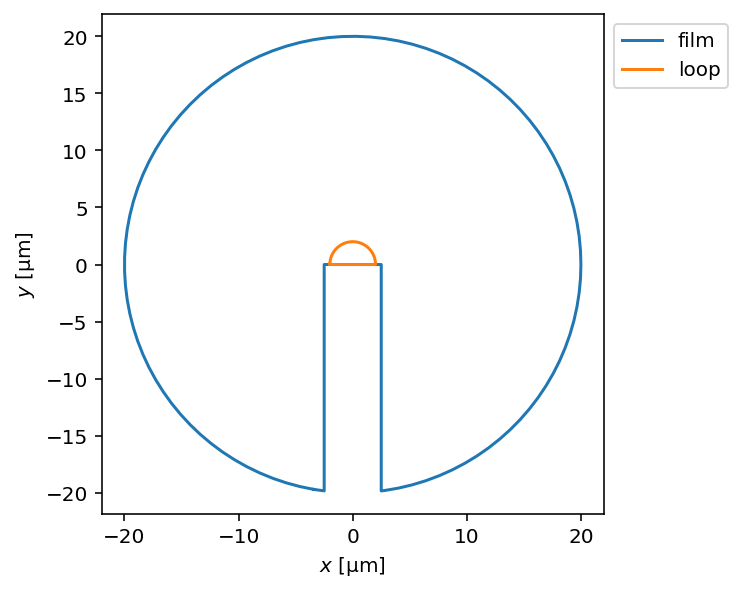

In [230]:
device.plot()

In [231]:
device.layer.Lambda

20.0

In [232]:
import logging


logging.basicConfig(level=logging.DEBUG)

In [233]:
device.make_mesh(min_points=None, max_edge_length=None, optimesh_steps=100)

In [234]:
device.points.shape[0]

2069

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$x$ $[\\mathrm{µm}]$', ylabel='$y$ $[\\mathrm{µm}]$'>)

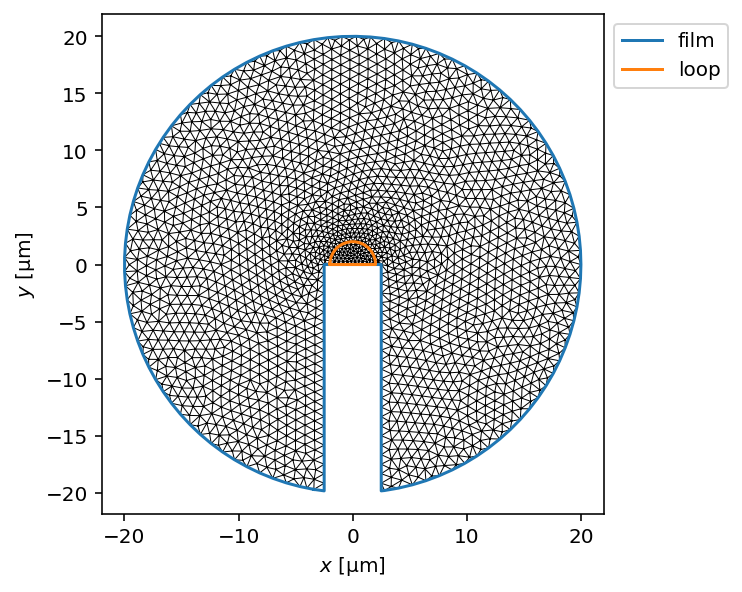

In [235]:
device.plot(mesh=True)

In [236]:
from tdgl.em import current_loop_vector_potential

def applied_potential(
    x, y, z,
    *,
    fc_radius, fc_center, fc_current,
    length_units="um", current_units="mA", field_units="mT",
):
    
    loop_center = np.atleast_2d(fc_center)
    loop_radius = fc_radius
    loop_current = fc_current

    positions = np.stack([x, y, z], axis=1)
    potential = current_loop_vector_potential(
        positions,
        loop_center=loop_center,
        current=loop_current,
        loop_radius=loop_radius,
        current_units=current_units,
        length_units=length_units,
    )
    return potential.to(f"{field_units} * {length_units}").m

In [237]:
# from tdgl.em import uniform_Bz_vector_potential

# ureg = device.ureg

# def applied_potential(x, y, z, field="1 uT"):
#     length_units = ureg(device.length_units)
#     positions = (
#         np.stack([x, y, z], axis=1) * length_units
#     ).to("m")
#     potential = uniform_Bz_vector_potential(positions, field)
#     return potential.to(f"mT * {device.length_units}").m

In [264]:
dt = 1e-2

solution = tdgl.solve(
    device,
    tdgl.Parameter(
        applied_potential,
        fc_radius=fc_radius,
        fc_center=(-2.5, 0, z0),
        fc_current=1.5,
        length_units=device.length_units,
        current_units="mA",
        field_units="mT",
    ),
#     tdgl.parameter.Parameter(applied_potential, field="50 uT"),
    "output1.h5",
    rtol=0,
    pinning_sites=0*10e-3,
    field_units="mT",
    gamma=10,
    dt=1e-3,
    skip=0,
    min_steps=None,
    max_steps=int(200 / dt),
    save_every=100,
    source_drain_current=0,
    include_screening=True,
)

Simulating: 100%|██████████| 20001/20001 [04:13<00:00, 78.81it/s] 


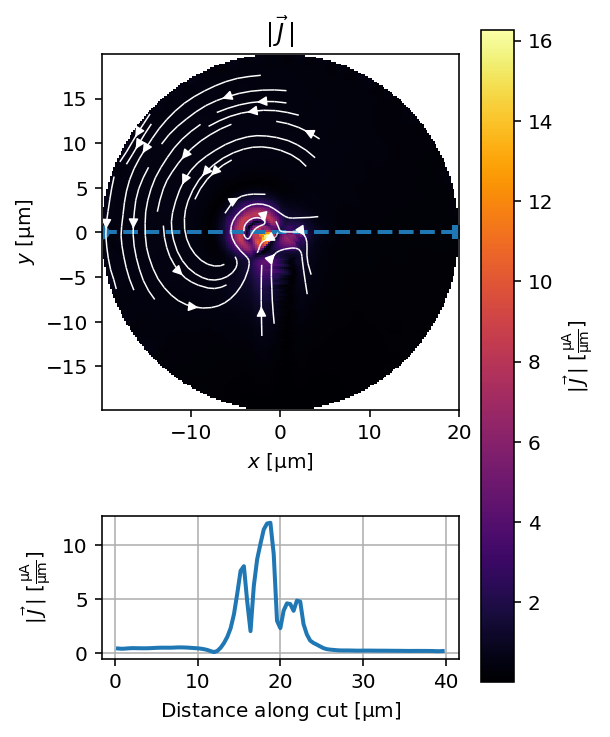

In [265]:
xs = np.linspace(-radius, radius, 101)
cross = [
    np.stack([xs, 0 * xs], axis=1)
]

_ = solution.plot_currents(cross_section_coords=cross, figsize=(4, 6), streamplot=True)

In [266]:
# solution.polygon_fluxoid(tdgl.geometry.circle(5))

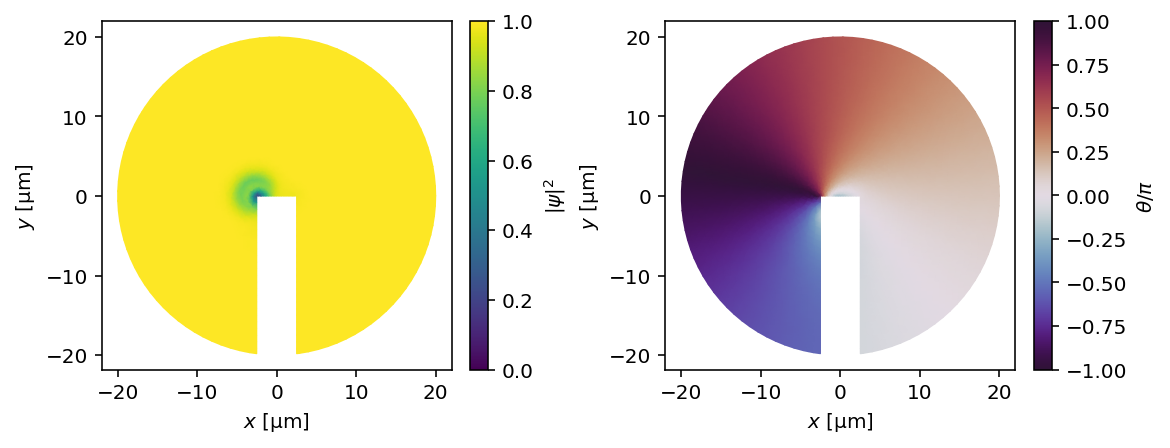

In [267]:
_ = solution.plot_order_parameter()

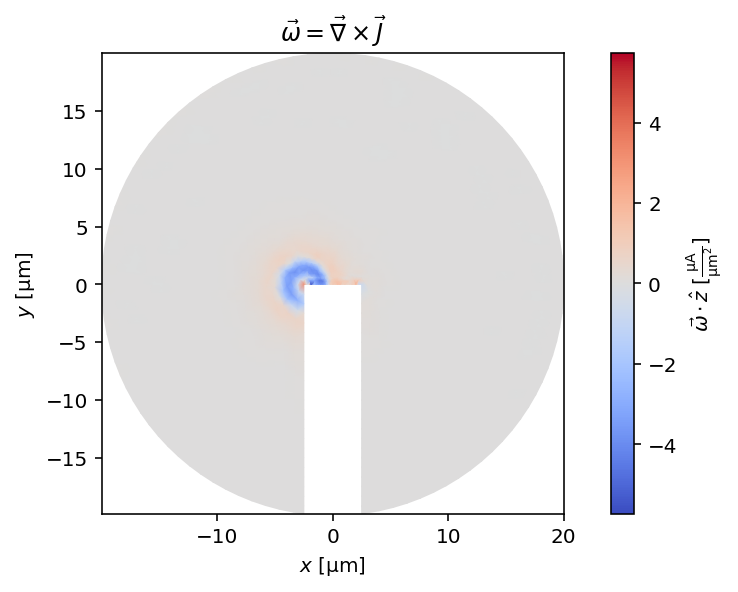

In [268]:
_ = solution.plot_vorticity(shading="gouraud")

In [ ]:
currents_rms = np.linspace(0.1, 10.1, 51)
thetas = 2 * np.pi * np.linspace(0, 3, (3 * 25) + 1, endpoint=False)
sin = np.sin(thetas)
cos = np.cos(thetas)
fields = {}

for current in currents_rms:
    fields[current] = []
    steps = 5_000
    save_every = 100
    seed = None
    for s in cos:
        solution = tdgl.solve(
            device,
            tdgl.Parameter(
                applied_potential,
                fc_radius=fc_radius,
                fc_center=(0, 0, z0),
                fc_current=current * s * np.sqrt(2),
            ),
            "output1.h5",
            pinning_sites=0,
            field_units="mT",
            gamma=1,
            dt=1e-2,
            skip=0,
            max_steps=steps,
            save_every=save_every,
            source_drain_current=0,
            seed_solution=seed,
            include_screening=True,
            rng_seed=42,
        )
        seed = solution
        steps = 500
        save_every = 10
        field = solution.field_at_position(
            pl_centroids,
            units="Phi_0 / um**2",
            with_units=False,
            return_sum=False,
        )
        fields[current].append(field)

In [ ]:
# flux_in_phase = np.array([np.sum(f.supercurrent * pl_areas) for f in fields])
# flux_oo_phase = np.array([np.sum(f.normal_current * pl_areas) for f in fields])

In [ ]:
flux = {}
for current, field in fields.items():
    flux[current] = np.array([np.sum(sum(f) * pl_areas) for f in field])

In [ ]:
fig, ax = plt.subplots()
for curr, phi in flux.items():
    ax.plot(phi, ".-")

In [ ]:
lockin = []
ix = slice(11, None)
for current in currents_rms:
    try:
        phi = flux[current]
        lockin.append(np.sum(phi[ix] * np.exp(-1j * (thetas[ix] - 0 * np.pi/2))) / current / sin[ix].size)
    except:
        pass
#     lockin.append(phi[0] / current)
    
lockin = 1e3 * np.array(lockin)

In [ ]:
lockin

In [ ]:
fig, ax = plt.subplots()
ax.plot(currents_rms[:len(lockin)], lockin.real, "C0o-")
ax.plot(currents_rms[:len(lockin)], lockin.imag, "C1o-")

In [ ]:
solution.plot_currents()

In [ ]:
# flux = flux_in_phase + flux_oo_phase

In [ ]:
X = np.sum(flux * sin)
Y = np.sum(flux * cos)

In [ ]:
1e3 * X / current, 1e3 * Y / current

In [ ]:
list(flux)

In [ ]:
fig, ax = plt.subplots()
colors = plt.get_cmap("inferno")(np.linspace(0, 1, len(flux)))
ofs = 0
for color, (current, phi) in zip(colors, list(flux.items())[:]):
    ax.plot(thetas[:], -phi[:] + ofs, ".-", color=color, label=f"{current:.2f}")
# ax.set_ylim(-6e-3, 6e-3)
bx = ax.twinx()
# bx.plot(thetas[:], cos[:], "C0o-")

In [ ]:
import h5py

In [ ]:
isinstance(h5py.Group, h5py.File)

In [ ]:
import os

In [ ]:
isinstance(str, os.PathLike)

In [ ]:
os.PathLike

In [ ]:
os.path.dirname(os.getcwd())

In [ ]:
str(np.int64)

In [ ]:
np.int64

In [ ]:
num_sites = 1000
num_edges = 3000
rho = np.random.random((num_edges, num_sites))[:, :, np.newaxis]
J = np.random.random((num_sites, 2))

In [ ]:
%%timeit
np.einsum("jk, ijk -> ik", J, rho, optimize=True)

In [ ]:
r1 = np.einsum("jk, ijk -> ik", J, rho, optimize=True)

In [ ]:
# rho = np.random.random((num_sites, num_edges))[:, :, np.newaxis]
rho2 = rho.transpose((1, 0, 2))

In [ ]:
%%timeit
np.einsum("ik, ijk -> jk", J, rho2, optimize=True)

In [ ]:
r2 = np.einsum("ik, ijk -> jk", J, rho2, optimize=True)

In [ ]:
np.allclose(r1, r2)

In [ ]:
import jax

In [ ]:
import jax.numpy as jnp

In [ ]:
r3 = np.array(jnp.einsum("jk, ijk -> ik", J, rho))

In [ ]:
np.allclose(r1, r3)

In [ ]:
%%timeit
np.array(jnp.einsum("jk, ijk -> ik", J, rho, optimize=True))

In [ ]:
%%timeit
np.array(jnp.einsum("jk, ijk -> ik", J, rho))